# Лаба 2

**Дедлайн**: 25 ноября

**Задача**: написать определитель тональности текста (сообщениея в Twitter) c помощью fine-tuning-а на датасете RuSentiTweet (https://github.com/sismetanin/rusentitweet)

На что обратить внимание:
(-)Подготовка данных (очистка, токенизация и упаковка датасета в удобный класс) - у вас в задании другой датасет, соответственно обработка может поменяться. В датасете несколько файлов, скачайте rusentitweet_full.csv и работайте с ним
(-)Процедура дообучения. Вам необходимо доработать имеющуюся процедуру:
    --(-) Добавить графики качества обучения модели в зависимости от шага (делать валидацию каждые 100 шагов (например), а не раз в эпоху)
    --(+) Замерить время обучения
    --(-) Добавить больше метрик для отслеживания (изучите по открытым источникам, какие метрики используются для задачи определения тональности и почему)
    --(-) Добавить заморозку части слоев (все, кроме слоя классификации, или кроме слоя классификации + 2-3 последних слоев с интентами)
    --(-) Подобрать количество эпох, размер батча и заморозку так, чтобы модель давала лучший результат
(-)Модель для дообучения (попробуйте как минимум 2 разных модели), искать подходящие модели можно с помощью гугла и https://huggingface.co/
(-)Результаты **всех** экспериментов должны быть описаны в отдельной ячейке
(-)Inference модели - обученную модель нужно обернуть в удобную функцию для использования, которая по тексту будет возвращать его тональность


https://www.youtube.com/watch?v=xI0HHN5XKDo

## Импорты

In [167]:
import helper, typing, re, torch, os.path

from num2words import num2words

from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import seaborn as sns

from cleantext import clean

import pandas as pd
import numpy as np

from pathlib import Path
import tqdm.notebook as tqdm

import emot
emot_core = emot.core.emot()

Разберемся с данными - уберем ненужные колонки, символы и т.д.

In [185]:
# Как всегда - на все случаи жизни есть библиотечки.
# Однако зачем-то я решил настолько очисткой заморочиться, что даже эмотиконы вытащил, и вот на это библиотек не было

def num2words_with_extract(text: typing.AnyStr) -> typing.AnyStr:
    split_text = text.split(' ')
    for idx, segment in enumerate(split_text):
        if segment.isdigit():
            split_text[idx] = num2words(segment, lang='ru')
    return " ".join(split_text)

def remove_emoticons(text: typing.AnyStr, emot_core) -> typing.AnyStr: # TODO: write your own emoticon regexp
    res = emot_core.emoticons(text)
    for emoticon in res['value']:
        # print(emoticon)
        regex = '(?:'
        for symbol in [*emoticon]:
            regex += (symbol if symbol.isalpha() or symbol.isdigit() else '\\' + symbol)+'+'
        regex += ')'
        # print(regex)
        compiled = re.compile(regex)
        text = compiled.sub(r'', text)
    return text


def clean_text(text: typing.AnyStr, emot_core=emot_core) -> typing.AnyStr:
    tag_pattern = re.compile("@\w*")
    text = tag_pattern.sub(r'', text)
    text = clean(
        text=text,
        fix_unicode=False,               # fix various unicode errors
        to_ascii=False,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=True,         # replace all phone numbers with a special token
        no_emoji=True,
        no_numbers=False,               # replace all numbers with a special token
        no_digits=False,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        normalize_whitespace=True,
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        # lang="en"                       # set to 'de' for German special handling
    )
    text = remove_emoticons(text, emot_core)
    text = num2words_with_extract(text)
    return text

clean_text("@varlamov @McFaul На Ой какие неожиданные :-( :3 100 результаты 🤭 https://t.co/ZwOHPDKUqq 88005553535", emot_core)

:-(
(?:\:+\-+\(+)
:3
(?:\:+3+)


'на ой какие неожиданные   сто результаты'

In [186]:
twitter_cut = None
csv_path = Path("csv")
twitter_full_path = csv_path / "twitter_full.csv"
twitter_cut_path = csv_path / "twitter_cut.pickle"

twitter = pd.read_csv(twitter_full_path)

if not os.path.exists(twitter_cut_path):
    print("Clearing initial csv and saving to pickle")
    twitter_cut = twitter.drop(["id", "Unnamed: 0"], inplace=False, axis=1) # .rename(columns={"Unnamed: 0": "index"})
    twitter_cut = twitter_cut[twitter_cut["label"] != "skip"]
    twitter_cut = twitter_cut.reset_index()
    twitter_cut.rename(columns={"index": "old_idx"}, inplace=True)
    twitter_cut["text_clean"] = twitter_cut["text"].apply(clean_text)
    twitter_cut.to_pickle(twitter_cut_path)
else:
    print("Loading existing pickle")
    twitter_cut = pd.read_pickle("./csv/twitter_cut.pickle")


Clearing initial csv and saving to pickle
:)
(?:\:+\)+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
*)
(?:\*+\)+)
:))
(?:\:+\)+\)+)
:(
(?:\:+\(+)
:3
(?:\:+3+)
:)
(?:\:+\)+)
:/
(?:\:+\/+)
;)
(?:\;+\)+)
:(
(?:\:+\(+)
:(
(?:\:+\(+)
:3
(?:\:+3+)
;)
(?:\;+\)+)
:/
(?:\:+\/+)
;)
(?:\;+\)+)
:)
(?:\:+\)+)
:*
(?:\:+\*+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:3
(?:\:+3+)
:/
(?:\:+\/+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
:(
(?:\:+\(+)
;)
(?:\;+\)+)
:)
(?:\:+\)+)
:3
(?:\:+3+)
:(
(?:\:+\(+)
:(
(?:\:+\(+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:]
(?:\:+\]+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
;)
(?:\;+\)+)
:)
(?:\:+\)+)
:3
(?:\:+3+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:/
(?:\:+\/+)
:(
(?:\:+\(+)
:(
(?:\:+\(+)
:))
(?:\:+\)+\)+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
;)
(?:\;+\)+)
:3
(?:\:+3+)
:)
(?:\:+\)+)
:)))
(?:\:+\)+\)+\)+)
:3
(?:\:+3+)
:))
(?:\:+\)+\)+)
:)
(?:\:+\)+)
;)
(?:\;+\)+)
:)
(?:\:+\)+)
:3
(?:\:+3+)
:&
(?:\:+\&+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:(
(?:\:+\(+)
:)
(?:\:+\)+)
:3
(?:\:+3+)
:)
(?:\:+\)+)
;;
(?:\;+

In [116]:
# twitter.head(10)

In [118]:
twitter_cut.head(100)

,old_idx,text,label,text_clean
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина
...,...,...,...,...
95,110,@snakey_ssnake Делать еще ╰(‵□′)╯ (мне понрави...,positive,делать еще ╰(‵□′)╯ (мне понравилось)
96,112,@cerealporridge 😭😭😭😭♥️♥️♥️♥️ спасибо 😭♥️♥️♥️♥️,speech,спасибо
97,114,В СевГУ прошел круглый стол по случаю Дня соли...,neutral,в севгу прошел круглый стол по случаю дня соли...
98,115,"@great_knee Бро,моя тоже",neutral,"бро,моя тоже"


In [91]:
def label_to_int(label):
    if label == 'negative':
        return 0
    elif label == 'neutral' or label == 'speech':
        return 1
    elif label == 'positive':
        return 2

twitter_cut["num_label"] = twitter_cut["label"].apply(label_to_int)

twitter_cut

,old_idx,text,label,text_clean,num_label
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1
...,...,...,...,...,...
11544,13386,Это просто промокод и он одноразовый! https://...,neutral,это просто промокод и он одноразовый!,1
11545,13387,все пора спать пиздец словила шизу,negative,все пора спать пиздец словила шизу,0
11546,13388,такими темпами я создам новую секту или органи...,neutral,такими темпами я создам новую секту или органи...,1
11547,13389,"Ты смотрела аниме, завернувшись в одеяло ,пока...",neutral,"ты смотрела аниме, завернувшись в одеяло ,пока...",1


[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

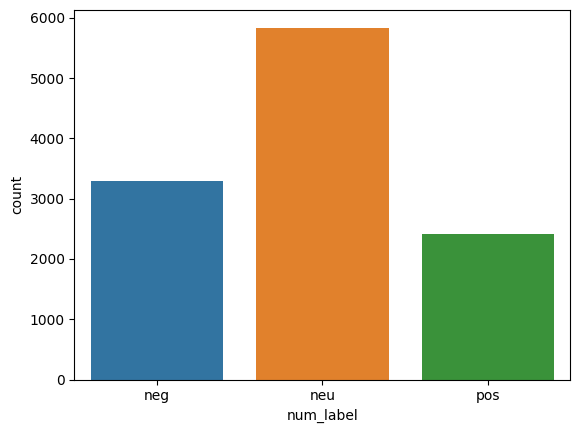

In [89]:
ax = sns.countplot(data=twitter_cut, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

Из-за того, что speech ушел в neutral, то у нас возникает дисбаланс (возможно с этим стоило что-то сделать)

In [170]:
text = "@varlamov @McFaul На Ой какие неожиданные :^( 100 результаты 🤭 https://t.co/ZwOHPDKUqq 88005553535"
remove_emoticons(text, emot_core)

'@varlamov @McFaul На Ой какие неожиданные :^( 100 результаты 🤭 httpst.co/ZwOHPDKUqq 88005553535'